## ARIMA Statistical Tests and Metrics



##This analysis develop a ARIMA dataset for forecasting daily minimum temperatures in Melbourne city. Using a popular dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.api as smt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA 

warnings.filterwarnings('ignore')

## Load data

<AxesSubplot:xlabel='data'>

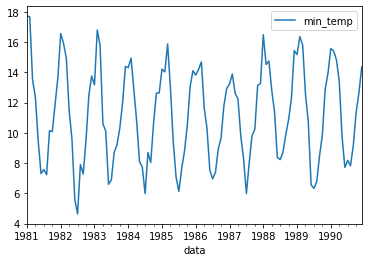

In [2]:
# Read in as csv and recast the index to datetime format
df = pd.read_csv('./data/daily-minimum-temperatures-in-me.csv',header = 0, index_col = 0, names = ['data','min_temp'])
df.index = pd.to_datetime(df.index)


# Create new monthly dataframe using resample; 
df_month= df.resample('M').mean()

#Plot month
df_month.plot()

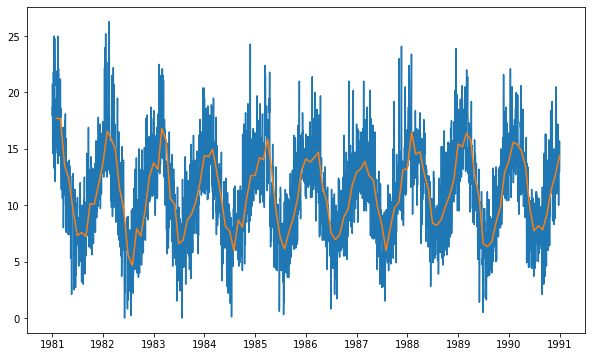

In [3]:
#Ambos combinados
plt.figure(figsize=(10, 6))
plt.plot(df)
plt.plot(df_month)

## Time series decomposition

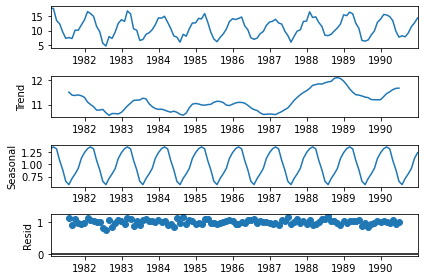

In [4]:
# Multiplicative decomposition
output = seasonal_decompose(df_month, model='multiplicative')
output.plot(); 

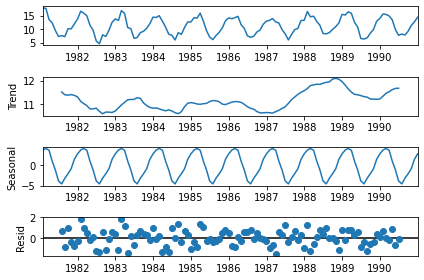

In [5]:
# todo: additive decomposition - Best model
output = seasonal_decompose(df_month, model='additive')
output.plot();

## Check for stationarity 

In [6]:
# define ADF test function
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic           -1.892313
p-value                   0.335686
Lags Used                13.000000
Observations Used       106.000000
Critical Value (1%)      -3.493602
Critical Value (5%)      -2.889217
Critical Value (10%)     -2.581533
dtype: float64


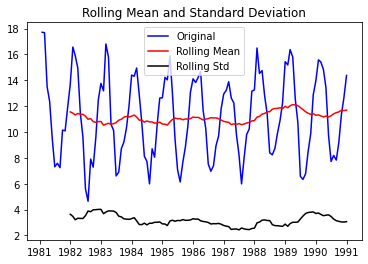

In [7]:
# Use dftest() to check whether our monthly time series is stationary
dftest(df_month)

p-value > 0.05 -> NON stationary series -> H0 hypothesis of unit-root (random walk) holds

## Differencing to get stationary time series

Test Statistic           -4.629576
p-value                   0.000114
Lags Used                12.000000
Observations Used       106.000000
Critical Value (1%)      -3.493602
Critical Value (5%)      -2.889217
Critical Value (10%)     -2.581533
dtype: float64


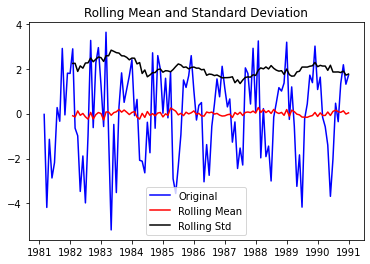

In [8]:
# Create new df with monthly data with a first difference 
diff_df_month = df_month.diff()[1:]

# Check whether monthly differenced series is stationary
dftest(diff_df_month)

Time series is now stationary. 

## ACF and PACF plots

In [9]:
def acf_pacf_plots(data, lags=None):
    # create the structure for the plots
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    # create the actual plots
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

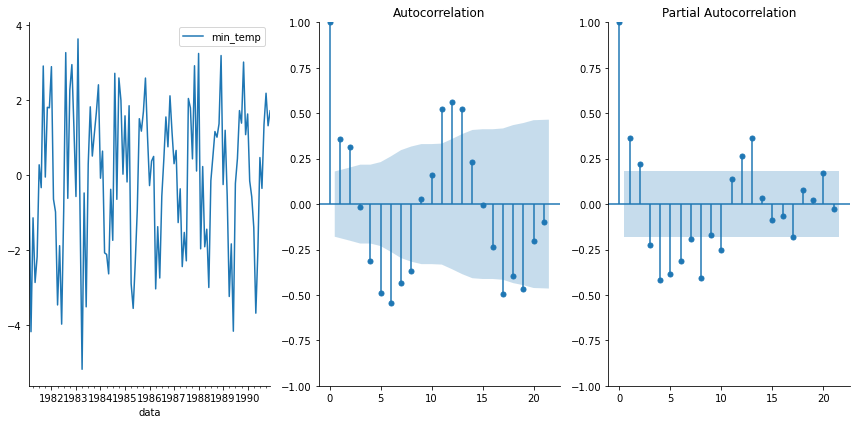

In [10]:
# Run the ACF and PACF plots of our monthly differenced data 
acf_pacf_plots(diff_df_month)

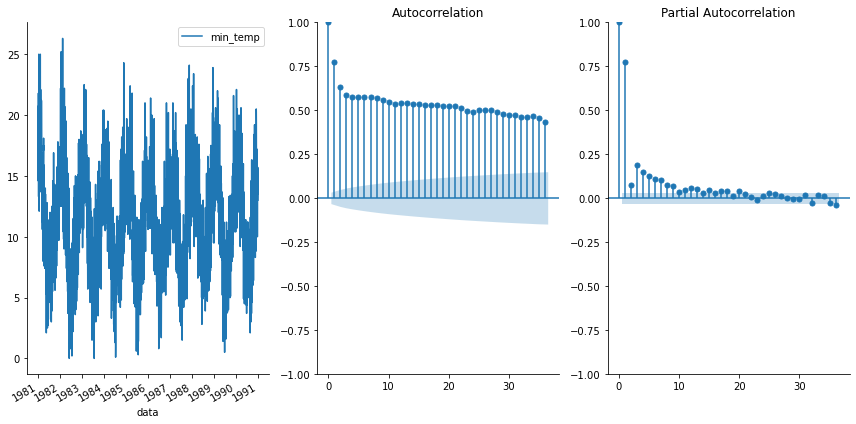

In [11]:
# todo: plot ACF and PACF for daily series
acf_pacf_plots(df)

### Train/test split and RMSE of AR model

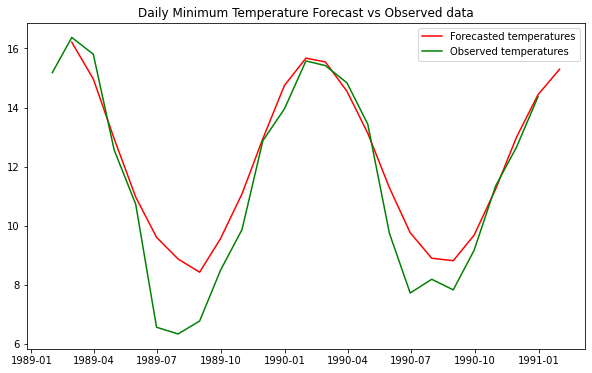

In [12]:
# Create train and test series (20% holdout)
train = df_month[:96] #pega a linha 0 e não prega 96
test =  df_month[96:]

# Use ARIMA().fit() to fit on the TRAIN dataset only
lag=9
AR_t = ARIMA(train, order = (lag,1,0)).fit()

# Use your fitted model from above, plus .predict(), to predict on the training data
sample_test = AR_t.predict(start=len(train)+1, end = len(train)+len(test), dynamic = True)

# todo: plot test and test_pred from the above cell on the same plot
plt.figure(figsize=(10, 6))
plt.title('Daily Minimum Temperature Forecast vs Observed data')
plt.plot(sample_test,'red', label = 'Forecasted temperatures')
plt.plot(test, 'green', label = 'Observed temperatures')
plt.legend()

### Calculate RMSE for the holdout data

In [13]:
# Calculate rmse 
rmse = sqrt(mean_squared_error(y_true = test , y_pred = sample_test))
print(f'RMSE = {rmse:.2f} degrees Celsius')

RMSE = 1.82 degrees Celsius
